## Estilização da Saída do Markdown

In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>


# Simulador de um Conversor Boost com CPL (Carga de Potência Constante)

## 1. Importação de Bibliotecas e Implementação de Funções Utilitárias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
ct.use_fbs_defaults()

In [3]:
def show_matrix(name, matrix, decimal_places=2):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + "e}"

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [4]:
def update_boost_translated_nonlinear(t, x, u, params):
  # Definição dos parâmetros do sistema
  V_IN = params.get('Vin')  # Tensão de Entrada
  R = params.get('R')       # Resistência (indutor)
  L = params.get('L')       # Indutância
  C = params.get('C')       # Capacitância
  OP = params.get('op')       # Capacitância

  # Entradas do sistema: Duty Cycle e Potência da CPL
  δD, δP_CPL = u

  # Estados do sistema: corrente do indutor e tensão do capacitor
  δiL, δvC = x

  # Atualização da corrente do indutor
  dδiL = - (V_IN / (L * OP['vC'])) * δvC + ((OP['vC'] + δvC) / L) * δD

  # Atualização da tensão do capacitor
  dδvC = ((1 - OP['d'] - δD) / C) * (OP['iL'] + δiL) - (OP['vC'] + δvC) / (R * C) - (OP['Pcpl'] + δP_CPL) / \
      (C * (OP['vC'] + δvC))

  dx = np.array([dδiL, dδvC])
  return dx

# Definição da saída do sistema


def output_boost_nonlinear(t, x, u, params):
  return x[0:2]


# Definição do conversor cc-cc boost nao-linear
boost_translated_nonlinear = ct.ss(
    update_boost_translated_nonlinear,
    output_boost_nonlinear,
    name='boost_translated_nonlinear',
    inputs=('δd', 'δPcpl'),
    outputs=('δiL', 'δvC'),
    states=('δiL', 'δvC')
)

## 3. Modelo Não-linear do Sistema


In [5]:
def update_boost_nonlinear(t, x, u, params):
  # Definição dos parâmetros do sistema
  V_IN = params.get('Vin')  # Tensão de Entrada
  R = params.get('R')       # Resistência (indutor)
  L = params.get('L')       # Indutância
  C = params.get('C')       # Capacitância

  # Entradas do sistema: Duty Cycle e Potência da CPL
  D, P_CPL = u

  # Estados do sistema: corrente do indutor e tensão do capacitor
  IL, VC = x

  # Atualização da corrente do indutor
  dIl = - ((1. - D) / L) * VC + (V_IN / L)

  # Atualização da tensão do capacitor
  dVc = ((1. - D) * IL) / C - VC / (R * C) - P_CPL / (C * VC)

  dx = np.array([dIl, dVc])
  return dx

# Definição da saída do sistema


def output_boost_nonlinear(t, x, u, params):
  return x[0:2]


# Definição do conversor cc-cc boost nao-linear
boost_nonlinear = ct.ss(
    update_boost_nonlinear,
    output_boost_nonlinear,
    name='boost_nonlinear',
    inputs=('d', 'P_cpl'),
    outputs=('iL', 'vC'),
    states=('iL', 'vC')
)

## 5. Simulação dos Modelos Não-lineares

#### 5.1 Definição dos Parâmetros da Simulação

 Especificação e atribuição dos valores iniciais aos parâmetros necessários para realizar a simulação do sistema.

In [6]:
def gen_u(timepts, values, D):
  U = np.zeros((2, len(timepts)))
  U[0, :] = D

  for i, t in enumerate(timepts):
    for j in range(len(values)-1):
      if values[j][0] <= t < values[j+1][0]:
        U[1, i] = values[j][1]
        break
    else:
      U[1, i] = values[-1][1]
  return U

In [7]:
# Parâmetros do Circuito

# Sistema Estável
params = {'Vin': 48, 'R': 20, 'L': 1e-3,
          'C': 2.2e-3, 'op': {'Pcpl': 600, 'vC': 72}}

# # Cálculo da Corrente e Duty Cycle de Operação
op = params['op']
IL_OP = (op['vC'] ** 2 + params['R'] * op['Pcpl']) / \
    (params['R'] * params['Vin'])
D_OP = 1 - params['Vin'] / op['vC']

params['op']['iL'] = IL_OP
params['op']['d'] = D_OP

# Ponto de operação de cada entrada e estado do sistema
U_OP = np.array([params['op']['d'], params['op']['Pcpl']])
X_OP = np.array([params['op']['iL'], params['op']['vC']])

# # Entradas do Sistema
D = params['op']['d']
P_CPL = params['op']['Pcpl']

values = [
    (0., 600)
]

step = 1e-5
timepts = np.arange(0, 2. + step, step)
U = gen_u(timepts, values, D)

# # Estados Iniciais do Sistema
IL_INIT = 1.5 * params['op']['iL']
VC_INIT = 0.25 * params['op']['vC']
X0 = np.array([IL_INIT, VC_INIT])

δU = U - U_OP[:, np.newaxis]
δX0 = X0 - X_OP

print('Parâmetros: ')
params

Parâmetros: 


{'Vin': 48,
 'R': 20,
 'L': 0.001,
 'C': 0.0022,
 'op': {'Pcpl': 600, 'vC': 72, 'iL': 17.9, 'd': 0.33333333333333337}}

#### 5.2 Resposta do Sistema Não Linear

Implementação do sistema com um entrada e condições iniciais específicos a fim de obter o comportamento dinâmico do sistema não linear.

### 5.3 Resposta do Sistema Não-linear Transladado

## 6. Modelo do Sistema Linearizado

### 6.2 Implementação do Sistema Linearizado

O código a seguir implementa o modelo linearizado em torno de um ponto de operação. Os parâmetros, entradas e estados do sistema são definidos.

In [8]:
# Obtenção dos valores no ponto de operação (OP)
OP = params['op']

# Elementos da matriz de estados
A11 = 0.
A12 = - ((1. - OP['d']) / params['L'])
A21 = (1. - OP['d']) / params['C']
A22 = (1. / params['C']) * \
    ((OP['Pcpl'] / (OP['vC'] ** 2)) - (1. / params['R']))

# Elementos da matriz de entrada
B21 = - (OP['iL'] / params['C'])
B22 = - 1. / (params['C'] * OP['vC'])
B11 = OP['vC'] / params['L']
B12 = 0.

# Matriz de estados: iL e vC
A = [[A11, A12], [A21, A22]]

# Matriz de entradas: d e P_cpl
B = [[B11, B12], [B21, B22]]

# Matriz de saída: iL e vC
C = [[1., 0], [0., 1]]

# Matriz de alimentação: nula
D = [[0., 0.], [0., 0.]]

boost_linearized = ct.ss2io(
    ss(A, B, C, D),
    name='boost_linearized',
    inputs=('δd', 'δPcpl'),
    outputs=('δiL', 'δvC'),
    states=('δiL', 'δvC')
)

### 6.3 Simulação do Sistema Linearizado

#### 7. Comparação dos Resultados Obtidos na Simulação

Nesta seção, exploramos visualmente o comportamento do sistema através de gráficos. A biblioteca Matplotlib é utilizada para criar visualizações que representam a resposta do sistema ao longo do tempo.

## 7. Implementação dos ETM Estático e Dinâmico

Nesta seção, apresentamos o modelo de ETM dinâmico e estático proposto por Coutinho, que será utilizado neste projeto. Este modelo se baseia em uma condição suficiente para permitir o projeto simultâneo do ETM e do controlador com ganhos escalonados, garantindo a estabilidade assintótica da origem do sistema em malha fechada. Além disso, aborda um problema de otimização visando a ampliação dos intervalos entre eventos, com o objetivo de minimizar a quantidade de eventos gerados pelo ETM.

In [9]:
# Definição dos parâmetros do problema de otimização
A = cp.Parameter((2, 2),
                 value=np.array([[A11, A12], [A21, A22]]))
BU = cp.Parameter((2, 1), value=np.array([[B11], [B12]]))
I = cp.Parameter((2, 2), name='I', value=np.identity(2))

# Definição das variáveis do problema de otimização
Ξ_TIL = cp.Variable((2, 2), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((2, 2), name='Ψ_TIL', PSD=True)
X = cp.Variable((2, 2), name='X', PSD=True)
K_TIL = cp.Variable((1, 2), name='K_TIL')

_lambda = .1

# Definição do problema: objetivo e restrições
obj = cp.Minimize(cp.trace(_lambda * Ξ_TIL + (1 - _lambda) * Ψ_TIL))

M11 = A @ X + BU @ K_TIL + X @ A.T + K_TIL.T @ BU.T
M12 = BU @ K_TIL
M13 = X

M21 = K_TIL.T @ BU.T
M22 = -Ξ_TIL
M23 = np.zeros(shape=(2, 2))

M31 = X
M32 = np.zeros(shape=(2, 2))
M33 = -Ψ_TIL

M = cp.bmat([[M11, M12, M13],
             [M21, M22, M23],
             [M31, M32, M33]])

print(M.shape)
constraints = [M << 0]
constraints += [1e-9 * np.eye(2) <= Ξ_TIL]
constraints += [Ξ_TIL <= 1e9 * np.eye(2)]
constraints += [1e-9 * np.eye(2) <= Ψ_TIL]
constraints += [Ψ_TIL <= 1e9 * np.eye(2)]
prob = cp.Problem(obj, constraints)

# Resolução do problema usando o solver MOSEK
prob.solve(solver=cp.MOSEK, verbose=False)

K = None
Ξ = None
Ψ = None
P = None

# Apresentação dos Resultados
if prob.status not in ["infeasible", "unbounded"]:
  print("Valor ótimo: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV

  _K = K_TIL @ X_INV
  K = _K.value

  show_matrix('K', K)

  Ψ = np.linalg.inv(Ψ_TIL.value)
  P = X_INV

  show_matrix('P', P)
  show_matrix('Ξ', Ξ),
  show_matrix('Ψ', Ψ),
else:
  print('O problema não é factível')

(6, 6)
Valor ótimo: 3.091639000123814e-08

Ξ_TIL =
    ┌                      ┐
    │  2.72e-07  -9.78e-21 │
    │ -9.78e-21   1.30e-08 │
    └                      ┘

Ψ_TIL =
    ┌                      ┐
    │  1.33e-09  -8.07e-23 │
    │ -8.07e-23   1.33e-09 │
    └                      ┘

X =
    ┌                      ┐
    │  3.71e-10  -4.98e-11 │
    │ -4.98e-11   1.62e-10 │
    └                      ┘

K_TIL =
    ┌                      ┐
    │ -7.05e-12  -1.65e-14 │
    └                      ┘

K =
    ┌                      ┐
    │ -1.98e-02  -6.19e-03 │
    └                      ┘

P =
    ┌                    ┐
    │ 2.81e+09  8.64e+08 │
    │ 8.64e+08  6.43e+09 │
    └                    ┘

Ξ =
    ┌                    ┐
    │ 2.16e+12  7.33e+11 │
    │ 7.33e+11  7.41e+11 │
    └                    ┘

Ψ =
    ┌                    ┐
    │ 7.49e+08  4.53e-05 │
    │ 4.53e-05  7.49e+08 │
    └                    ┘



# Estático

In [10]:
zero = 0
event_times_linear = [0.]


def get_gama(current_states, last_states_sent):
  error = last_states_sent - current_states
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error


def etm_output(t, x, u, params):
  global zero, event_times_linear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = Γ < 0

  if etm_output.first_simulation and trigger:
    event_times_linear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.ss(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.previous = []
zoh_output.last_states_sent = [0, 0]

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.ss(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
    (boost_linearized, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('boost_linearized.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'boost_linearized.δiL'),
        ('etm.x2', 'boost_linearized.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='closed_loop_buck_system',
    inplist=('boost_linearized.δPcpl'),
    outlist=('boost_linearized.δiL',
             'boost_linearized.δvC',
             'boost_linearized.δd',
             ),
    output=('δiL', 'δvC', 'u')
)

print(CLOSED_LOOP_BUCK_SYSTEM)
print('')

δPcpl = δU[1]

t, y_linear = ct.input_output_response(
    sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
    U=δPcpl,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

inter_event_times_linear = [0.]

for i in range(1, len(event_times_linear)):
  inter_event_times_linear.append(
      event_times_linear[i] - event_times_linear[i-1])

<InterconnectedSystem>: closed_loop_buck_system
Inputs (1): ['u[0]']
Outputs (3): ['δiL', 'δvC', 'u']
States (2): ['boost_linearized_δiL', 'boost_linearized_δvC']



In [11]:
zero = 0
event_times_nonlinear = [0.]


def get_gama(current_states, last_states_sent):
  error = last_states_sent - current_states
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error


def etm_output(t, x, u, params):
  global zero, event_times_nonlinear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = Γ < 0

  if etm_output.first_simulation and trigger:
    event_times_nonlinear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.ss(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.previous = []
zoh_output.last_states_sent = [0, 0]

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.ss(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

CLOSED_LOOP_BUCK_SYSTEM = ct.interconnect(
    (boost_translated_nonlinear, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('boost_translated_nonlinear.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'boost_translated_nonlinear.δiL'),
        ('etm.x2', 'boost_translated_nonlinear.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='closed_loop_buck_system',
    inplist=('boost_translated_nonlinear.δPcpl'),
    outlist=('boost_translated_nonlinear.δiL',
             'boost_translated_nonlinear.δvC',
             'boost_translated_nonlinear.δd',
             ),
    output=('δiL', 'δvC', 'u')
)

print(CLOSED_LOOP_BUCK_SYSTEM)
print('')

δPcpl = δU[1]

t, y_nonlinear = ct.input_output_response(
    sys=CLOSED_LOOP_BUCK_SYSTEM, T=timepts,
    U=δPcpl,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

inter_event_times_nonlinear = [0.]

for i in range(1, len(event_times_nonlinear)):
  inter_event_times_nonlinear.append(
      event_times_nonlinear[i] - event_times_nonlinear[i-1])

<InterconnectedSystem>: closed_loop_buck_system
Inputs (1): ['u[0]']
Outputs (3): ['δiL', 'δvC', 'u']
States (2): ['boost_translated_nonlinear_δiL', 'boost_translated_nonlinear_δvC']



In [12]:
def tempo_acomodacao(sinal, tempo):
  valor_final = sinal[-1]  # Último valor do sinal
  limite = 0.02 * valor_final

  for i in range(len(sinal) - 1, -1, -1):
    if abs(sinal[i] - valor_final) >= limite:
      return tempo[i], i
  return tempo[0], 0


mean = np.mean(np.array(inter_event_times_nonlinear))
print(f'Média ITEE: %.3e' % mean)
mean = np.mean(np.array(inter_event_times_linear))
print(f'Média ITEE: %.3e' % mean)

ts_nonlinear_value, ts_nonlinear_idx = tempo_acomodacao(
    y_nonlinear[1] + OP['vC'], t)
print(f'Tempo de Acomodação (não linear): %.3e' % ts_nonlinear_value)
ts_linear_value, ts_linear_idx = tempo_acomodacao(y_linear[1] + OP['vC'], t)
print(f'Tempo de Acomodação (linear): %.3e' % ts_linear_value)

Média ITEE: 1.201e-04
Média ITEE: 6.370e-05
Tempo de Acomodação (não linear): 8.580e-03
Tempo de Acomodação (linear): 9.770e-03


In [13]:
ise = np.trapz(y_nonlinear[1][:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('ise (não linear): %.2e' % ise)

ise = np.trapz(y_linear[1][:ts_linear_idx] ** 2, t[:ts_linear_idx])
print('ise (linear): %.2e' % ise)

itse = np.trapz(t[:ts_nonlinear_idx] * y_nonlinear[1]
                [:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('itse (não linear): %.2e' % itse)

itse = np.trapz(t[:ts_linear_idx] * y_linear[1]
                [:ts_linear_idx] ** 2, t[:ts_linear_idx])

print('itse (linear): %.2e' % itse)

isc = np.trapz((y_nonlinear[2]
               [:ts_nonlinear_idx] + OP['d']) ** 2, t[:ts_nonlinear_idx])
print('isc (não linear): %.2e' % isc)

isc = np.trapz((y_linear[2]
               [:ts_linear_idx] + + OP['d']) ** 2, t[:ts_linear_idx])

print('isc (linear): %.2e' % isc)

ise (não linear): 4.87e+00
ise (linear): 5.97e+00
itse (não linear): 4.28e-03
itse (linear): 8.99e-03
isc (não linear): 8.82e-04
isc (linear): 4.13e-04


# Dinâmico

In [14]:
zero = 0
event_times_linear = [0.]

θ = 1
λ = 100


def etm_update(t, n, u, params):
  last_states_sent = u[0:2]
  current_states = u[2:4]
  Γ = get_gama(current_states, last_states_sent)
  dn = -λ * n + Γ
  return [dn]


def etm_output(t, n, u, params):
  global zero, event_times_linear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = (n + θ * Γ) < 0

  if etm_output.first_simulation and trigger:
    event_times_linear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1], n[0]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    etm_update, etm_output,
    name='etm',
    states=('n'),
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2', 'n'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.lss = zoh_output.previous
    zoh_output.previous_time = t

  zoh_output.previous = u

  return zoh_output.lss


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.lss = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
    # states=1
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

SYS = ct.interconnect(
    (boost_linearized, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('boost_linearized.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'boost_linearized.δiL'),
        ('etm.x2', 'boost_linearized.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='conversor_system',
    inplist=('boost_linearized.δPcpl'),
    outlist=('boost_linearized.δiL',
             'boost_linearized.δvC',
             'boost_linearized.δd',
             'etm.n',
             ),
    output=('δIl', 'δVc', 'u', 'n')
)

print(SYS)
print('')

δPcpl = δU[1]

t, y_linear = ct.input_output_response(
    sys=SYS, T=timepts,
    U=δPcpl,
    X0=δX0 + [0.],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

inter_event_times_linear = [0.]

for i in range(1, len(event_times_linear)):
  inter_event_times_linear.append(
      event_times_linear[i] - event_times_linear[i-1])

<InterconnectedSystem>: conversor_system
Inputs (1): ['u[0]']
Outputs (4): ['δIl', 'δVc', 'u', 'n']
States (3): ['boost_linearized_δiL', 'boost_linearized_δvC', 'etm_n']



/home/andel/.local/lib/python3.10/site-packages/control/iosys.py:1798: UserWarning: initial state too short; padding with zeros
  warn("initial state too short; padding with zeros")


In [15]:
zero = 0
event_times_nonlinear = [0.]


def etm_update(t, n, u, params):
  last_states_sent = u[0:2]
  current_states = u[2:4]
  Γ = get_gama(current_states, last_states_sent)
  dn = -λ * n + Γ

  return [dn]


def etm_output(t, n, u, params):
  global zero, event_times_nonlinear

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = (n + θ * Γ) < 0

  if etm_output.first_simulation and trigger:
    event_times_nonlinear.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1], n[0]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    etm_update, etm_output,
    name='etm',
    states=('n'),
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2', 'n'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.lss = zoh_output.previous
    zoh_output.previous_time = t

  zoh_output.previous = u

  return zoh_output.lss


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.lss = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
    # states=1
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

SYS = ct.interconnect(
    (boost_translated_nonlinear, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('boost_translated_nonlinear.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'boost_translated_nonlinear.δiL'),
        ('etm.x2', 'boost_translated_nonlinear.δvC'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='conversor_system',
    inplist=('boost_translated_nonlinear.δPcpl'),
    outlist=('boost_translated_nonlinear.δiL',
             'boost_translated_nonlinear.δvC',
             'boost_translated_nonlinear.δd',
             'etm.n',
             ),
    output=('δIl', 'δVc', 'u', 'n')
)

print(SYS)
print('')

δPcpl = δU[1]

t, y_nonlinear = ct.input_output_response(
    sys=SYS, T=timepts,
    U=δPcpl,
    X0=δX0 + [0.],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step},
    params=params
)

inter_event_times_nonlinear = [0.]

for i in range(1, len(event_times_nonlinear)):
  inter_event_times_nonlinear.append(
      event_times_nonlinear[i] - event_times_nonlinear[i-1])

<InterconnectedSystem>: conversor_system
Inputs (1): ['u[0]']
Outputs (4): ['δIl', 'δVc', 'u', 'n']
States (3): ['boost_translated_nonlinear_δiL', 'boost_translated_nonlinear_δvC', 'etm_n']



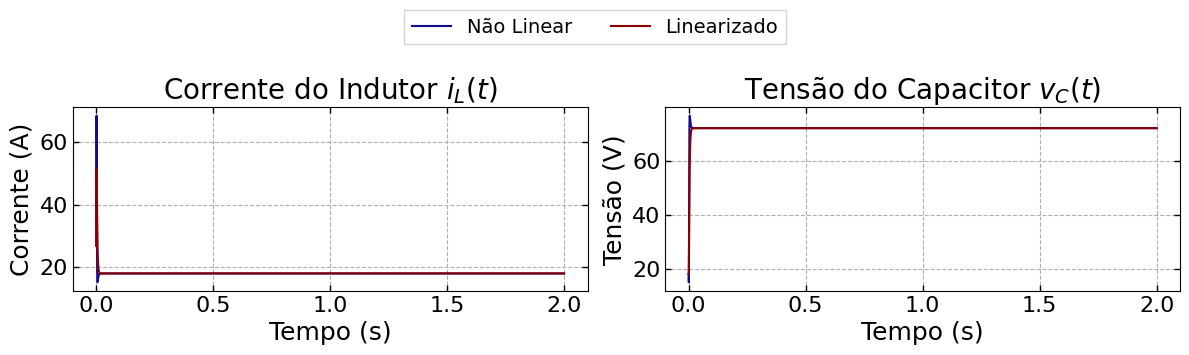

In [16]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

linewidth = 1.5

# Plotando o primeiro gráfico para a corrente do indutor
line1, = axs[0].plot(t, y_nonlinear[0] + params['op']['iL'],
                     linestyle='-', color='#120a8f', linewidth=linewidth, alpha=1)

line2, = axs[0].plot(t, y_linear[0] + params['op']['iL'], linestyle='-',
                     color='#8b0000', linewidth=linewidth, alpha=1)

axs[0].set_xlabel('Tempo (s)', fontsize=18)
axs[0].set_ylabel('Corrente (A)', fontsize=18)
axs[0].grid(linestyle='--')
axs[0].set_title('Corrente do Indutor $i_L(t)$', fontsize=20)
axs[0].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Plotando o segundo gráfico para a tensão do capacitor

axs[1].plot(t, y_nonlinear[1] + params['op']['vC'],
            linestyle='-', color='#120a8f', label='Não linear Transladado', linewidth=linewidth)

axs[1].plot(t, y_linear[1] + params['op']['vC'], linestyle='-',
            color='#8b0000', label='Linearizado', linewidth=linewidth)

axs[1].set_xlabel('Tempo (s)', fontsize=18)
axs[1].set_ylabel('Tensão (V)', fontsize=18)
axs[1].grid(linestyle='--')
axs[1].set_title('Tensão do Capacitor $v_C(t)$', fontsize=20)
axs[1].tick_params(axis='both', direction='in', length=4, width=1,
                   colors='black', top=True, right=True, labelsize=16)

# Criando uma única legenda para ambos os subplots
fig.legend([line1, line2], ['Não Linear', 'Linearizado'],
           fontsize=14, loc='upper center', bbox_to_anchor=(.5, 1.2), fancybox=False, shadow=False, ncol=2)

# Ajustando o layout para evitar sobreposição
plt.tight_layout()

In [17]:
def tempo_acomodacao(sinal, tempo):
  valor_final = sinal[-1]  # Último valor do sinal
  limite = 0.02 * valor_final

  for i in range(len(sinal) - 1, -1, -1):
    if abs(sinal[i] - valor_final) >= limite:
      return tempo[i], i
  return tempo[0], 0


mean = np.mean(np.array(inter_event_times_nonlinear))
print(f'Média ITEE: %.3e' % mean)
mean = np.mean(np.array(inter_event_times_linear))
print(f'Média ITEE: %.3e' % mean)

ts_nonlinear_value, ts_nonlinear_idx = tempo_acomodacao(
    y_nonlinear[1] + OP['vC'], t)
print(f'Tempo de Acomodação (não linear): %.3e' % ts_nonlinear_value)
ts_linear_value, ts_linear_idx = tempo_acomodacao(y_linear[1] + OP['vC'], t)
print(f'Tempo de Acomodação (linear): %.3e' % ts_linear_value)

Média ITEE: 1.871e-04
Média ITEE: 6.008e-04
Tempo de Acomodação (não linear): 8.570e-03
Tempo de Acomodação (linear): 9.780e-03


In [18]:
ise = np.trapz(y_nonlinear[1][:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('ise (não linear): %.2e' % ise)

ise = np.trapz(y_linear[1][:ts_linear_idx] ** 2, t[:ts_linear_idx])
print('ise (linear): %.2e' % ise)

itse = np.trapz(t[:ts_nonlinear_idx] * y_nonlinear[1]
                [:ts_nonlinear_idx] ** 2, t[:ts_nonlinear_idx])
print('itse (não linear): %.2e' % itse)

itse = np.trapz(t[:ts_linear_idx] * y_linear[1]
                [:ts_linear_idx] ** 2, t[:ts_linear_idx])

print('itse (linear): %.2e' % itse)

isc = np.trapz((y_nonlinear[2]
               [:ts_nonlinear_idx] + OP['d']) ** 2, t[:ts_nonlinear_idx])
print('isc (não linear): %.2e' % isc)

isc = np.trapz((y_linear[2]
               [:ts_linear_idx] + + OP['d']) ** 2, t[:ts_linear_idx])

print('isc (linear): %.2e' % isc)

ise (não linear): 4.86e+00
ise (linear): 5.97e+00
itse (não linear): 4.27e-03
itse (linear): 9.00e-03
isc (não linear): 8.80e-04
isc (linear): 4.14e-04
